In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
dataset=pd.read_csv('updated_dmart_products_final.csv')

In [4]:
print(dataset.head(10))

                Name    Brand  Price  DiscountedPrice           Category  \
0  Premia Tea Masala   Premia   39.0               35  Dairy & Beverages   
1        Amul Butter     Amul  255.0              245  Dairy & Beverages   
2        Amul Butter     Amul   52.0               48  Dairy & Beverages   
3        Amul Butter     Amul  106.0               98  Dairy & Beverages   
4        Society Tea  Society  140.0              130  Dairy & Beverages   

  SubCategory Quantity                                        Description  \
0   Beverages    50 gm  Benefits Our chai masala combo benefits your h...   
1       Dairy   500 gm  OverviewMade from the freshest of cream, the A...   
2       Dairy   100 gm  OverviewMade from the freshest of cream, the A...   
3       Dairy   200 gm  OverviewMade from the freshest of cream, the A...   
4   Beverages   250 gm  Crushed, twisted and curled, each tea leaf car...   

                     BreadCrumbs  shelf_life  inventory_count  season  \
0  Dair

In [7]:
features=['Price','SubCategory','shelf_life','inventory_count','current_sales','max_shelf_life']
target='DiscountedPrice'



In [11]:
X=dataset[features]
y=dataset[target]

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Price','shelf_life', 'max_shelf_life', 'inventory_count', 'current_sales']),
        ('cat', OneHotEncoder(), ['SubCategory'])
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Price', 'shelf_life',
                                                   'max_shelf_life',
                                                   'inventory_count',
                                                   'current_sales']),
                                                 ('cat', OneHotEncoder(),
                                                  ['SubCategory'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [14]:

y_pred = pipeline.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Absolute Error: 24.664837545126353
Mean Squared Error: 3962.8705754512653
R^2 Score: 0.9710284560960671


In [37]:
import pickle

with open('wal_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [18]:

new_data = pd.DataFrame({
    'Price':[106],
    'SubCategory': ['Dairy'],
    'shelf_life': [2],
    'max_shelf_life': [21],
    'inventory_count': [776],
    'current_sales': [75706]
})


predicted_discounted_price = pipeline.predict(new_data)
print(f'Predicted Discounted Price: {predicted_discounted_price[0]}')


Predicted Discounted Price: 97.65


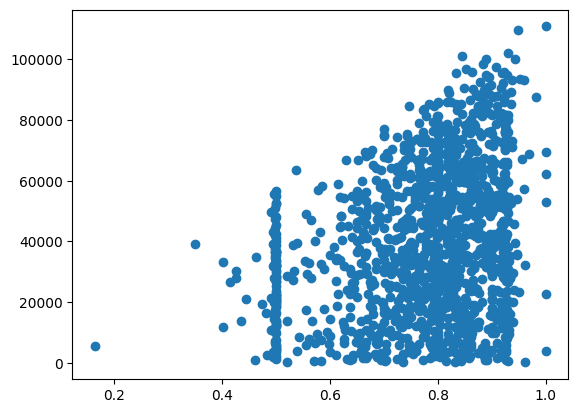

In [20]:
plt.scatter(dataset['DiscountedPrice']/dataset['Price'],dataset['current_sales'])


In [21]:
# Access feature importances from the trained model
importances = pipeline.named_steps['model'].feature_importances_

# Get the feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to view feature importance
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)


                                              Feature  Importance
0                                          num__Price    0.979597
3                                num__inventory_count    0.008058
1                                     num__shelf_life    0.003631
4                                  num__current_sales    0.003395
11                        cat__SubCategory_Dry Fruits    0.001740
5                          cat__SubCategory_Beverages    0.001108
6                        cat__SubCategory_Cooking Oil    0.000737
2                                 num__max_shelf_life    0.000639
15                  cat__SubCategory_Ghee & Vanaspati    0.000402
14                              cat__SubCategory_Geep    0.000231
21                   cat__SubCategory_Masala & Spices    0.000168
23              cat__SubCategory_Rice & Rice Products    0.000060
8   cat__SubCategory_DMart Grocery/Rice & Rice Pro...    0.000051
9                              cat__SubCategory_Dairy    0.000040
12        

In [22]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.6 MB/s eta 0:00:00


Predicted Discounted Price: 863.44


<ipython-input-35-27c1df823253>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean SHAP Value', y='Feature', data=negative_shap_df, palette='Blues_r')


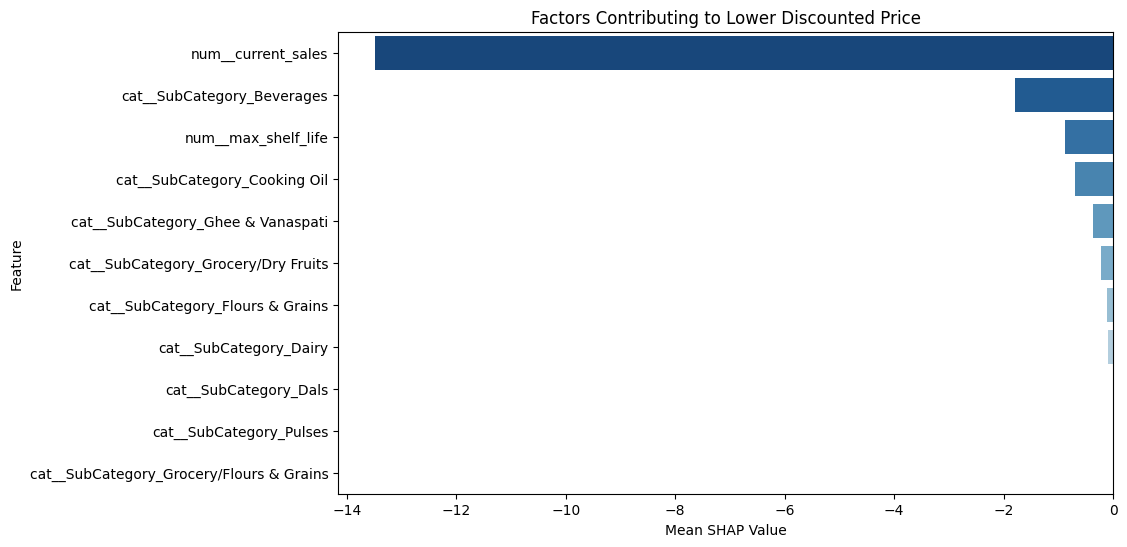

In [35]:
import shap
import seaborn as sns


# Initialize SHAP JavaScript visualization
shap.initjs()

# Convert the sparse matrix to a dense format
X_train_dense = pipeline.named_steps['preprocessor'].transform(X_train).toarray()

# Create the SHAP explainer using the dense matrix
explainer = shap.Explainer(pipeline.named_steps['model'], X_train_dense)

# Example of making a prediction with new data
new_data = pd.DataFrame({
    'Price': [1000],
    'SubCategory': ['Grocery/Dry Fruits'],
    'shelf_life': [364],
    'max_shelf_life': [365],
    'inventory_count': [500],
    'current_sales': [50]
})

# Predict the discounted price
predicted_discounted_price = pipeline.predict(new_data)
print(f'Predicted Discounted Price: {predicted_discounted_price[0]}')

# Transform the new data and convert to dense format
transformed_new_data_dense = pipeline.named_steps['preprocessor'].transform(new_data).toarray()

# Calculate SHAP values for the new data
shap_values = explainer(transformed_new_data_dense)

# Get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

mean_shap_values = np.mean(shap_values.values, axis=0)

# Create a DataFrame for filtering negative impacts
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': mean_shap_values
})

# Filter for negative impacts only
negative_shap_df = shap_df[shap_df['Mean SHAP Value'] < 0].sort_values(by='Mean SHAP Value')

# Plot the SHAP values for features contributing to lower the price
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean SHAP Value', y='Feature', data=negative_shap_df, palette='Blues_r')
plt.title('Factors Contributing to Lower Discounted Price')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

In [36]:
most_influential_feature = negative_shap_df.iloc[0]


print(f"The feature that most significantly lowers the discounted price is '{most_influential_feature['Feature']}' with a mean SHAP value of {most_influential_feature['Mean SHAP Value']:.4f}.")

The feature that most significantly lowers the discounted price is 'num__current_sales' with a mean SHAP value of -13.4869.
